# Importing Packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import mplsoccer
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from getCarries import getCarries
import scipy
from scipy.spatial import ConvexHull
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans

# Loading Data 

In [4]:
dir_name = r"D:\Analytics\Football\Barcalytix\Data\---\Barcelona\21-22"

# specifying an empty list for content
df_list = []
for file in os.listdir(dir_name):
    df = pd.read_csv(dir_name+'\\'+file)
    x = getCarries(df,65)
    df = df.append(x,ignore_index=True)
    df_list.append(df)

# Data Prep

In [2]:
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',150)

In [3]:
plt.rcParams['font.sans-serif'] = "Arial Rounded MT Bold"
plt.rcParams['font.family'] = "sans-serif"

In [5]:
full_df = pd.DataFrame()
full_df = pd.concat(df_list)
full_df.reset_index(inplace=True,drop=True)

In [6]:
full_df['recipient'] = full_df['playerId'].shift(-1)
full_df['recipientName'] = full_df['playerName'].shift(-1)

In [7]:
carriesGarcia = full_df[(full_df['playerId']==368091)&(full_df['type']=='Carry')]
passesGarcia = full_df[(full_df['playerId']==368091)&(full_df['type']=='Pass')&(full_df['outcomeType']=='Successful')]

In [8]:
def isProgressivePass(x,y,endX,endY):
    x = x*1.05
    y = y*0.68
    endX = endX*1.05
    endY = endY*0.68
    
    initDistanceFromGoal = np.sqrt(np.square(105-x)+np.square(34-y))
    finalDistanceFromGoal = np.sqrt(np.square(105-endX)+np.square(34-endY))
    
    
    if (x<=52.5 and endX<=52.5):
        if initDistanceFromGoal - finalDistanceFromGoal > 30:
            return True
    elif (x<=52.5 and endX>52.5):
        if initDistanceFromGoal - finalDistanceFromGoal > 15:
            return True
    elif (x>52.5 and endX>52.5):
        if initDistanceFromGoal - finalDistanceFromGoal > 10:
            return True
    return False

In [9]:
def isProgressiveCarry(x,y,endX,endY):
    x = x*1.05
    y = y*0.68
    endX = endX*1.05
    endY = endY*0.68
    
    
    
    initDistanceFromGoal = np.sqrt(np.square(105-x)+np.square(34-y))
    finalDistanceFromGoal = np.sqrt(np.square(105-endX)+np.square(34-endY))
    
    
    if x > 40*1.05:
        if initDistanceFromGoal - finalDistanceFromGoal > 5:
            return True
    return False

In [10]:
passesGarcia['Progressive'] = passesGarcia.apply(lambda row: isProgressivePass(row['x'],row['y'],row['endX'],row['endY']),axis=1)
progPasses = passesGarcia[passesGarcia['Progressive']==True]

In [11]:
carriesGarcia['Progressive'] = carriesGarcia.apply(lambda row: isProgressiveCarry(row['x'],row['y'],row['endX'],row['endY']),axis=1)
progCarries = carriesGarcia[carriesGarcia['Progressive']==True]

In [13]:
progPassCoords = np.array(progPasses[['x','y','endX','endY']]) 

In [14]:
kmeans = KMeans(n_clusters=3,random_state=32)
kmeans.fit(progPassCoords)
progPasses['cluster'] = kmeans.predict(progPassCoords)

In [15]:
progPasses['cluster'].value_counts()

1    17
0    13
2    11
Name: cluster, dtype: int64

In [16]:
progPasses[progPasses['cluster']==0].recipientName.value_counts()

Memphis Depay        5
Sergio Agüero        4
Riqui Puig           2
Frenkie de Jong      1
Philippe Coutinho    1
Name: recipientName, dtype: int64

In [17]:
def clusterColor(val):
    if val==0:
        return '#4da3ff'
    elif val==1:
        return '#cf0000'
    elif val==2:
        return '#f5c800'

In [18]:
progPasses['clusterColor'] = progPasses.apply(lambda x: clusterColor(x['cluster']),axis=1)

# Visualizations

## Progressive Passing Clusters

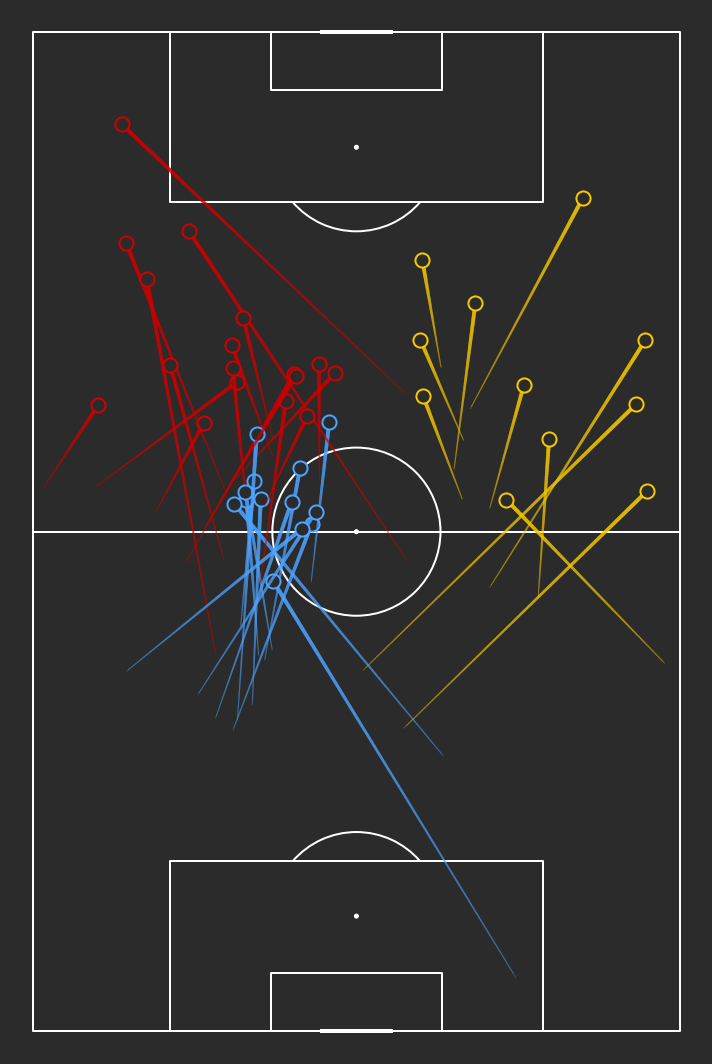

In [19]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white') 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')

for index,row in progPasses.iterrows():
    lines = pitch.lines(row.x,row.y,
                        row.endX,row.endY,
                        color=row.clusterColor,
                        comet=True,transparent=True,alpha_end=0.7,alpha_start=0.3,
                        linewidth=4,
                        zorder=1, ax=ax)
    nodes = pitch.scatter(row.endX,row.endY,
                          color='#2b2b2b',edgecolor=row.clusterColor,
                          s=200,linewidth=2,
                          zorder=1,ax=ax)
    

# ax.patch.set_facecolor('None')
# fig.set_alpha = 0.0
# fig.patch.set_visible(False)

# fig.savefig(r'D:\Analytics\Football\Trials\Figures\GarciaProgPasses.png',dpi=300,bbox_inches='tight')

## Progressive Carries

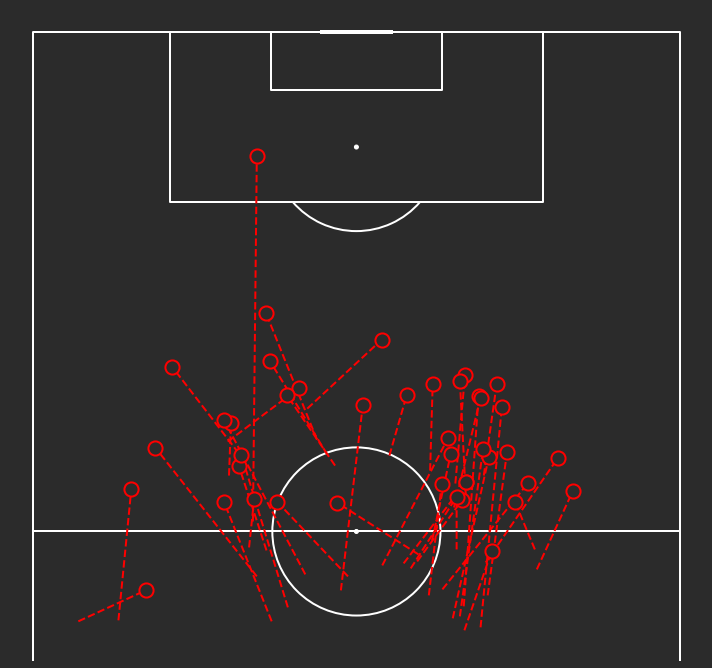

In [20]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white', half=True, pad_bottom=20) 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')

lines = pitch.lines(progCarries['x'],progCarries['y'],
                    progCarries['endX'],progCarries['endY'],
                    color='r',linestyle='dashed',
#                     transparent=True,alpha_end=0.7,alpha_start=0.3,
                    linewidth=2,
                    zorder=1, ax=ax)
nodes = pitch.scatter(progCarries['endX'],progCarries['endY'],s=200,
                      color='#2b2b2b',
                      edgecolor='red',linewidth=2,
                      ax=ax)

# ax.patch.set_facecolor('None')
# fig.set_alpha = 0.0
# fig.patch.set_visible(False)

# fig.savefig(r'D:\Analytics\Football\Trials\Figures\GarciaProgCarries.png',dpi=300,bbox_inches='tight')

## Defensive Actions and Territory

In [21]:
defActions = full_df[full_df['playerId']==368091]
defActions = defActions[(defActions['type']=='BallRecovery') | (defActions['type']=='BlockedPass') | (defActions['type']=='Clearance') | (defActions['type']=='Tackle') | 
                 (defActions['type']=='Interception') | (defActions['type']=='Aerial') & (defActions['defensiveDuel']==True)]
defActions = defActions[defActions['outcomeType']=='Successful']
defActions.reset_index(inplace=True,drop=True)
trueDefActions = defActions[(defActions['type']=='BallRecovery')]
# | (defActions['type']=='Interception')]

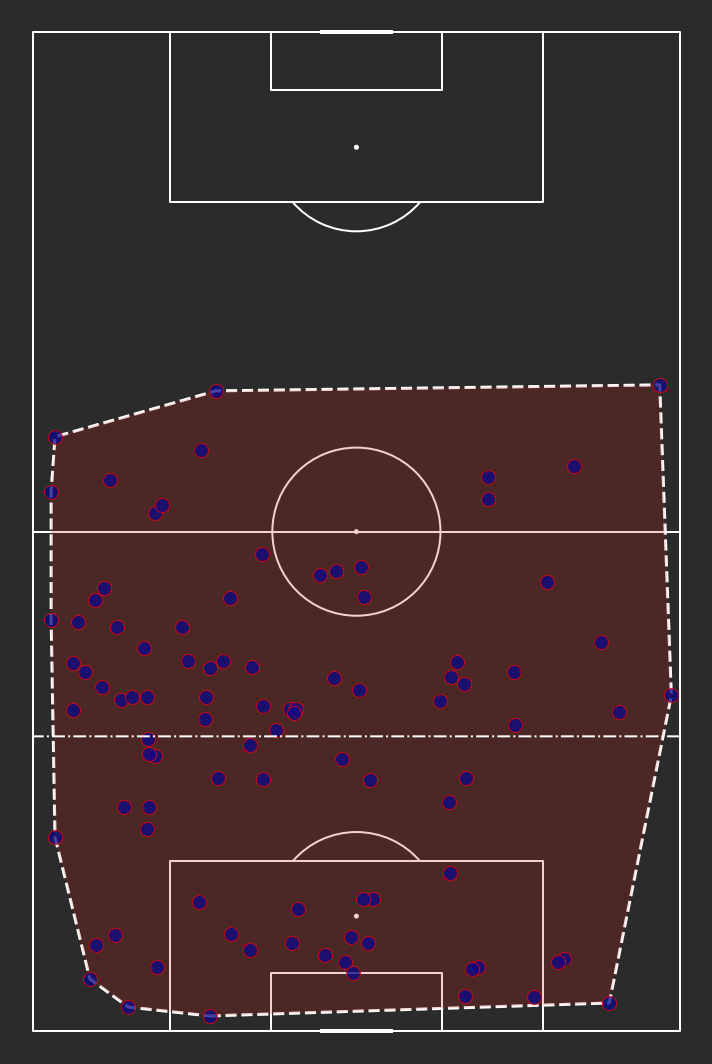

In [22]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white') 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')

hull = pitch.convexhull(defActions.x, defActions.y)

poly = pitch.polygon(hull, ax=ax, edgecolor='w', facecolor='none', linewidth=3,linestyle='dashed')

poly = pitch.polygon(hull, ax=ax, edgecolor='w', facecolor='#cc1b0e', alpha=0.2,linewidth=3,linestyle='dashed')


nodes = pitch.scatter(defActions['x'],defActions['y'],s=200,
                      color='#0c0987', alpha=0.75,
                      edgecolor='r',
                      ax=ax)

pitch.lines(defActions['x'].mean(),0,
            defActions['x'].mean(),100,
            color='white',linestyle='-.',
            linewidth=2,alpha=1,
            ax=ax)


# ax.patch.set_facecolor('None')
# fig.set_alpha = 0.0
# fig.patch.set_visible(False)

# fig.savefig(r'D:\Analytics\Football\Trials\Figures\GarciaDefActions.png',dpi=300,bbox_inches='tight')